In [1]:
import random
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import os
import pandas as pd
import json
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision

In [2]:
seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
def make_datapath_list(rootpath):
    '''
    学習、検証の画像データとアノテーションデータ、マスクデータへのファイルパスリストを作成
    '''
    json_path = os.path.join(rootpath, 'COCO.json')
    with open(json_path) as data_file:
        data_this = json.load(data_file)
        data_json = data_this['root']
        
    # indexを格納
    num_samples = len(data_json)
    train_indexes = []
    val_indexes = []
    for count in range(num_samples):
        if data_json[count]['isValidation'] != 0:
            val_indexes.append(count)
        else:
            train_indexes.append(count)
    
    # 画像ファイルパスを格納
    train_img_list = []
    val_img_list = []
    
    for idx in train_indexes:
        img_path = os.path.join(rootpath, data_json[idx]['img_paths'])
        train_img_list.append(img_path)
        
    for idx in val_indexes:
        img_path = os.path.join(rootpath, data_json[idx]['img_paths'])
        val_img_list.append(img_path)
        
    # mask dataのパスを格納
    train_mask_list = []
    val_mask_list = []
    
    for idx in train_indexes:
        img_idx = data_json[idx]['img_paths'][-16:-4]
        anno_path = './data/mask/train2014/mask_COCO_train2014_' + img_idx + '.jpg'
        train_mask_list.append(anno_path)
        
    for idx in val_indexes:
        img_idx = data_json[idx]['img_paths'][-16:-4]
        anno_path = './data/mask/val2014/mask_COCO_val2014_' + img_idx + '.jpg'
        val_mask_list.append(anno_path)
    
    # annotation dataを格納
    train_meta_list = []
    val_meta_list = []
    
    for idx in train_indexes:
        train_meta_list.append(data_json[idx])
    for idx in val_indexes:
        val_meta_list.append(data_json[idx])
        
    return train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list
    

In [4]:
# check
train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list = make_datapath_list(rootpath='./data/')

In [5]:
val_meta_list[24]

{'dataset': 'COCO_val',
 'isValidation': 1.0,
 'img_paths': 'val2014/COCO_val2014_000000000488.jpg',
 'img_width': 640.0,
 'img_height': 406.0,
 'objpos': [233.075, 275.815],
 'image_id': 488.0,
 'bbox': [180.76, 210.3, 104.63, 131.03],
 'segment_area': 4851.846,
 'num_keypoints': 15.0,
 'joint_self': [[266.0, 231.0, 1.0],
  [0.0, 0.0, 2.0],
  [264.0, 229.0, 1.0],
  [0.0, 0.0, 2.0],
  [256.0, 231.0, 1.0],
  [261.0, 239.0, 1.0],
  [238.0, 239.0, 1.0],
  [267.0, 259.0, 1.0],
  [222.0, 262.0, 1.0],
  [272.0, 267.0, 1.0],
  [243.0, 256.0, 1.0],
  [244.0, 278.0, 1.0],
  [229.0, 279.0, 1.0],
  [269.0, 297.0, 1.0],
  [219.0, 310.0, 1.0],
  [267.0, 328.0, 1.0],
  [192.0, 329.0, 1.0]],
 'scale_provided': 0.356,
 'joint_others': [[[0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [174.0, 261.0, 1.0],
   [169.0, 275.0, 1.0],
   [155.0, 275.0, 1.0],
   [190.0, 282.0, 1.0],
   [142.0, 299.0, 1.0],
   [217.0, 285.0, 1.0],
   [133.0, 329.0, 1.0],
   [0.0, 0.0, 2.0],
   [

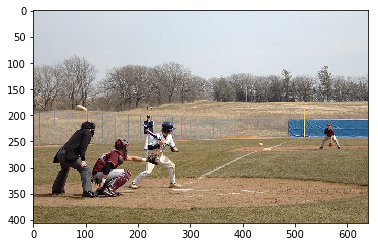

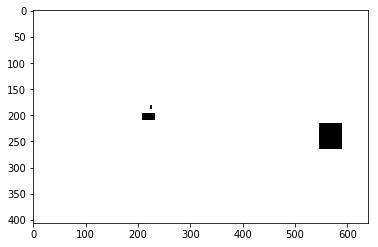

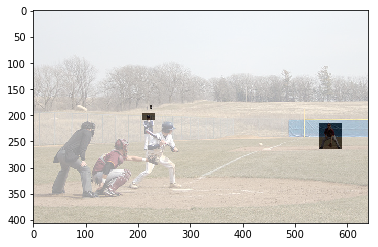

In [6]:
# mask dataの働きを確認
index = 24
img = cv2.imread(val_img_list[index])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

mask_miss = cv2.imread(val_mask_list[index])
mask_miss = cv2.cvtColor(mask_miss, cv2.COLOR_BGR2RGB)
plt.imshow(mask_miss)
plt.show()

blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()

In [7]:
val_mask_list[24]

'./data/mask/val2014/mask_COCO_val2014_000000000488.jpg'

In [8]:
# 画像の前処理作成
from utils.data_augumentation import Compose, get_anno, add_neck, aug_scale, aug_rotate, aug_croppad, aug_flip, remove_illegal_joint, Normalize_Tensor, no_Normalize_Tensor

class DataTransform():
    def __init__(self):
        self.data_transform = {
            'train': Compose([
                get_anno(),
                add_neck(),
                aug_scale(),
                aug_rotate(),
                aug_croppad(),
                aug_flip(),
                remove_illegal_joint(),
                # Normalize_Tensor()
                no_Normalize_Tensor()
            ]),
            'val': Compose([]) #省略
        }
    def __call__(self, phase, meta_data, img, mask_miss):
        meta_data, img, mask_miss = self.data_transform[phase](meta_data, img, mask_miss)
        
        return meta_data, img, mask_miss
    

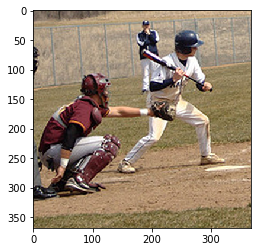

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


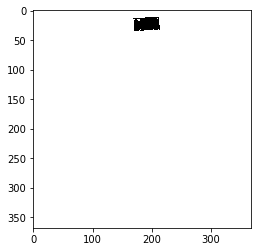

img.shape: (368, 368, 3)
mask_miss.shape: (368, 368, 3)


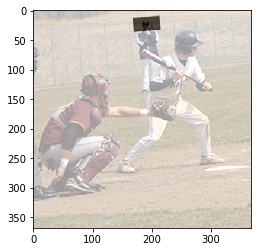

In [9]:
# check
index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meta_data = val_meta_list[index]

transform = DataTransform()
meta_data, img, mask_miss = transform('train', meta_data, img, mask_miss)

img = img.numpy().transpose((1, 2, 0))
plt.imshow(img)
plt.show()

mask_miss = mask_miss.numpy().transpose((1, 2, 0))
plt.imshow(mask_miss)
plt.show()

img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))
mask_miss = Image.fromarray(np.uint8(mask_miss))
mask_miss = np.asarray(mask_miss.convert('RGB'))
print(f'img.shape: {img.shape}')
print(f'mask_miss.shape: {mask_miss.shape}')
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()

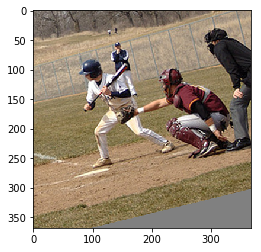

In [10]:
from utils.dataloader import get_ground_truth

index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meta_data = val_meta_list[index]

meta_data, img, mask_miss = transform('train', meta_data, img, mask_miss)

img = img.numpy().transpose((1, 2, 0))
mask_miss = mask_miss.numpy().transpose((1, 2, 0))

heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(meta_data, mask_miss)

plt.imshow(img)
plt.show()

img.shape: (368, 368, 3), heat_map.shape: torch.Size([46, 46])
img.shape: (368, 368, 3), heat_map.shape: (368, 368, 3)


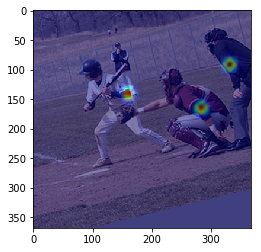

In [11]:
# 左肘のheatmapを確認 
img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))

heat_map = heatmaps[:, :, 6]
print(f'img.shape: {img.shape}, heat_map.shape: {heat_map.shape}')
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
print(f'img.shape: {img.shape}, heat_map.shape: {heat_map.shape}')
blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()

In [12]:
# Datasetの作成
from utils.dataloader import get_ground_truth

class COCOkeypointsDataset(data.Dataset):
    def __init__(self, img_list, mask_list, meta_list, phase, transform):
        self.img_list = img_list
        self.mask_list = mask_list
        self.meta_list = meta_list
        self.phase = phase
        self.transform = transform
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):
        img, heatmaps, heat_mask, pafs, paf_mask = self.pull_item(index)
        return img, heatmaps, heat_mask, pafs, paf_mask
    
    def pull_item(self, index):
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)
        
        mask_miss = cv2.imread(self.mask_list[index])
        meta_data = self.meta_list[index]
        
        meta_data, img, mask_miss = self.transform(self.phase, meta_data, img, mask_miss)
        
        mask_miss_numpy = mask_miss.numpy().transpose((1,2,0))
        heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(meta_data, mask_miss_numpy)
        
        heat_mask = heat_mask[:, :, :, 0]
        paf_mask = paf_mask[:, :, :, 0]
        
        paf_mask = paf_mask.permute(2, 0, 1)
        heat_mask = heat_mask.permute(2, 0, 1)
        pafs = pafs.permute(2, 0, 1)
        heatmaps = heatmaps.permute(2, 0, 1)
        
        return img, heatmaps, heat_mask, pafs, paf_mask

In [13]:
# check
train_dataset = COCOkeypointsDataset(val_img_list, val_mask_list, val_meta_list, phase='train', transform=DataTransform())
val_dataset = COCOkeypointsDataset(val_img_list, val_mask_list, val_meta_list, phase='val', transform=DataTransform())

item = train_dataset.__getitem__(0)
print(item[0].shape)
print(item[1].shape)

torch.Size([3, 368, 368])
torch.Size([19, 46, 46])


In [14]:
# DataLoaderの作成
batch_size = 8

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

In [17]:
# 動作の確認
batch_iterator = iter(dataloaders_dict['train'])
item = next(batch_iterator)

print(item[0].shape) # img
print(item[1].shape) # heatmap
print(item[2].shape) # heat_mask
print(item[3].shape) # pafs
print(item[4].shape) # paf_mask

torch.Size([8, 3, 368, 368])
torch.Size([8, 19, 46, 46])
torch.Size([8, 19, 46, 46])
torch.Size([8, 38, 46, 46])
torch.Size([8, 38, 46, 46])
